In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from utils import *

### Initialize Tagger

In [2]:
from tagger import Tagger
tagger = Tagger()

### Load Model and Data

In [90]:
model_path = ''
task_name = 'QQP'
split = 'dev'
filepath = f'{task_name}_{split}_error_analysis.tsv'
print(filepath)

QQP_dev_error_analysis.tsv


In [91]:
# # Load model and data
# model, dl = load_data_and_model(model_path,task_name,split)

# # Create DataFrame of Raw Data, Predictions, and Labels
# print('Creating dataframe')
# df_error = create_dataframe(task_name, model, dl)
# print('Created dataframe')

# # Save (and reload) DataFrame
# csv_path = '/'.join(model_path.split('/')[0:-1])
# save_dataframe(df_error, filepath)

df_error = load_dataframe(filepath)
df_error.head()

,Unnamed: 0,sentence1,sentence2,score,label,uid,pred,is_wrong
0,0,why are african - americans so beautiful ?,why are hispanic ##s so beautiful ?,0.017592,0,QQP/dev.tsv:2,0,False
1,1,i want to pursue phd in computer science abou...,i handle social media for a non - profit . sh...,0.001446,0,QQP/dev.tsv:3,0,False
2,2,is there a reason why we should travel alone ?,what are some reasons to travel alone ?,0.935732,1,QQP/dev.tsv:4,1,False
3,3,why are people so obsessed with having a girl...,how can a single male have a child ?,0.001505,0,QQP/dev.tsv:5,0,False
4,4,what are some good baby girl names starting w...,what are some good baby girl names starting w...,0.149290,0,QQP/dev.tsv:6,0,False


## Sandbox for Error Analysis

Plotting probabilities from the first column of Y_probs


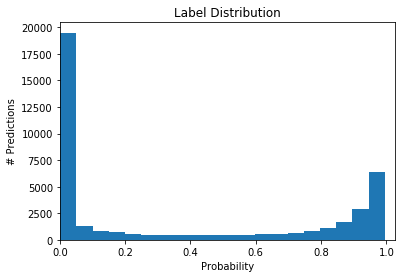

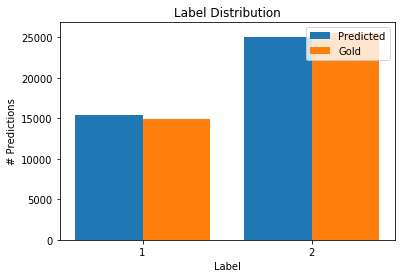

Plotting probabilities from the first column of Y_probs


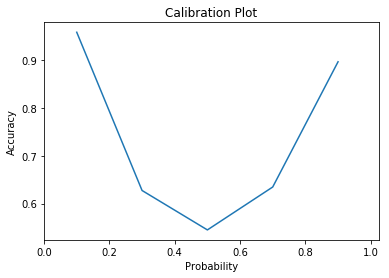

In [92]:
from metal.analysis import confusion_matrix
from metal.utils import convert_labels

Y_gold = convert_labels(df_error['label'].values, "onezero", "categorical")
Y_preds = convert_labels(df_error['pred'].values, "onezero", "categorical")
Y_probs = np.vstack([df_error['score'].values, 1 - df_error['score'].values]).transpose()

from metal.contrib.visualization.analysis import (
        plot_predictions_histogram, 
        plot_probabilities_histogram,
        plot_calibration_plot
    )
plot_probabilities_histogram(Y_probs, title="Label Distribution")
plot_predictions_histogram(Y_preds, Y_gold, title="Label Distribution")
plot_calibration_plot(Y_probs, Y_gold, title="Calibration Plot", bins=5)

# Examples we got barely right, barely wrong, and very wrong

In [93]:
print("\033[1mBARELY RIGHT\033[0;0m")
print_barely_right(df_error, thresh=0.2, n=1)
print("\033[1mBARELY WRONG\033[0;0m")
print_barely_wrong(df_error, thresh=0.2, n=1)
print("\033[1mVERY WRONG\033[0;0m")
print_very_wrong(df_error, thresh=0.8, n=1)

BARELY RIGHT
2086 matches were found with the given criteria.

UID:  QQP/dev.tsv:32238
sentence1: 	 why do people get it ##chy ? 
sentence2: 	 why am i so it ##chy ? 
score: 	0.3989
label: 	0

BARELY WRONG
1614 matches were found with the given criteria.

UID:  QQP/dev.tsv:15821
sentence1: 	 how can i put my pictures on google images ? 
sentence2: 	 how is a picture added to google images ? 
score: 	0.3457
label: 	1

VERY WRONG
2148 matches were found with the given criteria.

UID:  QQP/dev.tsv:33796
sentence1: 	 is it safe to eat food after ants have gotten to it ? 
sentence2: 	 is it safe to use sugar which ants have gotten into ? 
score: 	0.0609
label: 	1



# Slicing

In [94]:
from metal.mmtl.debugging.utils import print_row, apply_lfs_to_df, view_matches
from metal.mmtl.debugging.lf_helpers import regex_present
df_error.head()

,Unnamed: 0,sentence1,sentence2,score,label,uid,pred,is_wrong
0,0,why are african - americans so beautiful ?,why are hispanic ##s so beautiful ?,0.017592,0,QQP/dev.tsv:2,0,False
1,1,i want to pursue phd in computer science abou...,i handle social media for a non - profit . sh...,0.001446,0,QQP/dev.tsv:3,0,False
2,2,is there a reason why we should travel alone ?,what are some reasons to travel alone ?,0.935732,1,QQP/dev.tsv:4,1,False
3,3,why are people so obsessed with having a girl...,how can a single male have a child ?,0.001505,0,QQP/dev.tsv:5,0,False
4,4,what are some good baby girl names starting w...,what are some good baby girl names starting w...,0.149290,0,QQP/dev.tsv:6,0,False


In [95]:
def slicing_function(row):
    if '-' in row['sentence1'] or ';' in row['sentence1']:
        return True
    else: 
        return False
    
df = df_error[['sentence1','sentence2']].apply(slicing_function, axis=1)
in_slice = df_error[df]

In [96]:
from metal.analysis import confusion_matrix
from metal.utils import convert_labels

Y_gold = convert_labels(df_error['label'].values, "onezero", "categorical")
Y_preds = convert_labels(df_error['pred'].values, "onezero", "categorical")
Y_probs = np.vstack([df_error['score'].values, 1 - df_error['score'].values]).transpose()
print('IN ENTIRE DATASET')

from metal.metrics import metric_score
metric_list = ['accuracy','precision', 'recall', 'f1']

for metric in metric_list:
    score = metric_score(Y_gold, Y_preds, metric, probs=Y_probs)
    print(f"{metric.capitalize()}: {score:.3f}")
print(f'There are {len(df_error)} examples in the dataset')
    
Y_gold = convert_labels(in_slice['label'].values, "onezero", "categorical")
Y_preds = convert_labels(in_slice['pred'].values, "onezero", "categorical")
Y_probs = np.vstack([in_slice['score'].values, 1 - in_slice['score'].values]).transpose()
print('\nIN SLICE')
    
from metal.metrics import metric_score
metric_list = ['accuracy','precision', 'recall', 'f1']

for metric in metric_list:
    score = metric_score(Y_gold, Y_preds, metric, probs=Y_probs)
    print(f"{metric.capitalize()}: {score:.3f}")
print(f'There are {len(in_slice)} examples in the slice')

IN ENTIRE DATASET
Accuracy: 0.887
Precision: 0.836
Recall: 0.863
F1: 0.849
There are 40430 examples in the dataset

IN SLICE
Accuracy: 0.932
Precision: 0.836
Recall: 0.834
F1: 0.835
There are 1564 examples in the slice


In [97]:
filename = f'slices/{task_name}_{split}_dashsemicolon.tsv'
print(in_slice)
in_slice['uid'].to_csv(filename,sep='\t',header=False,index=False)

       Unnamed: 0                                          sentence1  \
0               0        why are african - americans so beautiful ?    
29             29   " who is the adam the lyrics to blink - 182 '...   
44             44   how could an hiv - positive person have child...   
46             46   why ms dh ##oni leave captain ##cy of odi & t...   
77             77   are rolls - royce cars given only to reputed ...   
91             91   which is the best way to pass the 74 - 322 ex...   
94             94   is wi ##mps incorrect ? will wave - particle ...   
111           111   who was a better offensive tackle - jim parke...   
127           127   which aircraft was superior - the douglas dc ...   
162           162   is there any way to recover e - mail ##s that...   
200           200   question that contains assumptions : why do p...   
260           260   what are the best techniques for off - page s...   
278           278   how should i prepare for nee ##t - 2017 in 6

**1. Number Based LF**

Our model tends to fail when there are numbers involved in the two sentences. We can look for the same number being repeated in both sentences as an LF

**2. Edit Distance Based LF**

Our model tends to vote entailment when one sentence is long and the other is short. We can focus on this slice and flip the labelt o vote no entailment even when the number of words is the same.